## Time series analysis with neural networks
What do we cover in this notebook?
- Time series data generation using *Gaussian processes*, as well as their mathematical background.
- Sequential data preparation for use in deep learning models.
- Fitting classical models like arima using the library `statsmodels`.
- Explanation of miscellaneous bits and blops not explained before, like the `TensorDataset` class, the `nn.Sequential` layer, ...

In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt

### Simulation of data
##### Theory
We will simulate data from a Gaussian process with a *RBF kernel*, that is 
$$k(x_i,x_j)= e^{-|x_i-x_j|^2 / 2l^2}.$$
This means that we are generating data coming from a stochastic process such that for any $(t_1, \ldots,t_n)$ we have that $$(X_{t_1}, \ldots, X_{t_n}) \sim MVN(0,K), $$
where $K=[k(t_i,t_j)]_{i,j}$ is the covariance matrix specified by the kernel defining the Gaussian process. The parameter $l$ controls how rough our path is. If $l$ is small then even close samples will be nearly independent so it's produce very wiggly paths. On the contrary, large $l$ will lead to smooth functions.
##### Practice
Remember that to generate this data our algorithm will calculate covariance matrix K and then simulate data from the corresponding multivariate normal distribution. How is this done? To generate $(x_{t_1}, \ldots, x_{t_n})$ you first generate independent samples from a standard normal distribution $(z_{t_1}, \ldots, z_{t_n})$ and then apply the transformation $x_i = K^{1/2}z_i$, which has the desired distribution.

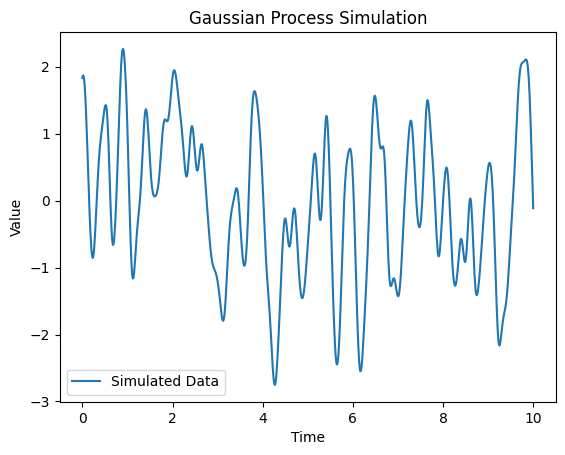

In [46]:
# Define the kernel and the Gaussian process
kernel = RBF(length_scale=0.1)
gp = GaussianProcessRegressor(kernel=kernel)

# Simulate data
T = 1000  # Number of time steps
X = np.linspace(0, 10, T).reshape(-1, 1)  # Reshapes linspace to 2D array (the -1 tells me to infer the number of rows based on the number of data points)  
y_mean, y_cov = gp.predict(X, return_cov=True)  # Mean and covariance of GP

# Sample from the Gaussian process
data = np.random.multivariate_normal(y_mean.ravel(), y_cov, size=1).T # .ravel() flattens the array to 1D, and size=1 means we want one sample

# Plot the simulated data
plt.plot(X, data, label="Simulated Data")
plt.title("Gaussian Process Simulation")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

### Preparing the data
- Right now we have a univariate time series $(x_1, \ldots, x_T)$ but we want to prepare the data to be inputted in our deep learning models. This means that we have to prepare them into batches $(x_{t-p}, \ldots, x_t, y_{t+h})$ and put them into our `DataLoader`. To do so we use a class called `TensorDataset` which is useful in supervised learning to bind covariates with their labels. Then we use the `DataLoader` to create the iterable set of batches which our model can accept as input. 
- As per usual, we include a training dataset and a testing one for later testing.

In [47]:

p = 30  # Past window size
h = 1   # Forecast horizon
testing_length = round(T/10)

# Prepare input-output pairs using sliding window
X_train, Y_train, X_test, Y_test = [], [], [], []

for t in range(T - p - h- testing_length):  # Make sure we have enough room for input and target
        X_train.append(data[t:t + p])  # Past p steps
        Y_train.append(data[t + p + h - 1])  # Future value at step t + p + h
for t in range(T - p - h- testing_length, T - p - h):  # Testing data
        X_test.append(data[t:t + p])  # Past p steps
        Y_test.append(data[t + p + h - 1])  # Future value at step t + p + h

# Convert to numpy arrays
X_train = np.array(X_train).reshape(-1, p)  # Reshape to (num_samples, p)
Y_train = np.array(Y_train).reshape(-1, 1)  # Reshape to (num_samples, 1)
X_test = np.array(X_test).reshape(-1, p)  # Reshape to (num_samples, p)
Y_test = np.array(Y_test).reshape(-1, 1)  # Reshape to (num_samples, 1)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


# Create DataLoader for batching
batch_size = 32
training_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
testing_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


### A simple neural network model
- Nothing we haven't seen before, except maybe the `nn.Sequential` layer, which simply concatenates layers together. It's useful is you're planning re-using some combination of layers (eg. linear, ReLU, linear, ReLU) throughout the architecture. 
- We include linear layers, a 1D convolutional layer, pooling and some regularisation with dropouts.

In [48]:
class SimpleNN(nn.Module):
    def __init__ (self):
        super(SimpleNN, self).__init__()
        self.first = nn.Sequential(
            nn.Linear(p,64), # Input: p, output: 64
            nn.ReLU(), 
            nn.Linear(64, 32), # Input: 64, output: 32
            nn.ReLU()
        )
        self.conv = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3) # Input: 32, Output: (30,2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2) # Input: (30,2), Output: (15,2)
        self.flatten = nn.Flatten() # Input: (15,2), Output: (30)
        self.fc = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.first(x)
        x = self.dropout(x)
        x = x.unsqueeze(1) # Add channel dimension for Conv1d as it expects (batch_size, in_channels, length)
        x = self.conv(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Training

In [49]:
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    for i, (X_batch, Y_batch) in enumerate(training_dataloader):
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0117
Epoch [20/100], Loss: 0.0181
Epoch [30/100], Loss: 0.0324
Epoch [40/100], Loss: 0.0273
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0538
Epoch [70/100], Loss: 0.0039
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0298
Epoch [100/100], Loss: 0.0192


### Testing

Test Loss: 0.0504


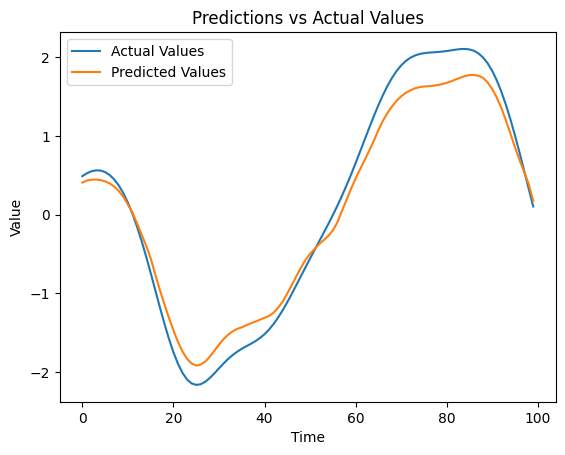

In [50]:
model.eval()  # Set the model to evaluation mode
loss = 0
predictions = []
actuals = []

with torch.no_grad():
    for (X_batch, Y_batch) in testing_dataloader:
        prediction = model(X_batch)
        predictions.append(prediction.numpy())
        actuals.append(Y_batch.numpy())
        test_loss = criterion(prediction, Y_batch)
        loss += test_loss.item()
    loss /= len(testing_dataloader)
    print(f'Test Loss: {loss:.4f}')

# Plot predictions vs actual valuesç
plt.plot(Y_test, label='Actual Values')
plt.plot(np.concatenate(predictions), label='Predicted Values')
plt.title("Predictions vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


### Comparison with classical models
- We now wish to compare the performace of this deep model with a classical arima model. Classical models tend to work better when the dataset is small and the forecasting period is not too big.
- We can use classical models by employing either `statsmodels`. If we want to use autoArima, then we'll need to use `pmdarima`.
- Let's start by fitting an AR(2) model.

/home/se24/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/se24/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/se24/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/se24/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/se24/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conver

ARIMA Test Loss: 0.0141


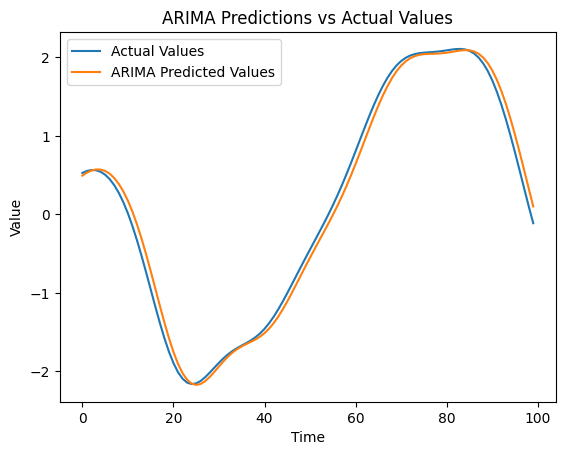

In [68]:
import statsmodels.api as sm # the .api contains high-level methods for statistical models
predictions, actual = [], []
loss = 0

# Fit the model
for t in range(T-testing_length-h,T-h):
    model = sm.tsa.ARIMA(data[0:t], order=(2, 0, 0))
    model_fit = model.fit()
    forecast = float(model_fit.forecast(steps=h)[-1])
    predictions.append(forecast)
    actual.append(data[t + h])
    loss += (forecast - data[t + h]) ** 2 
loss /= len(predictions)
loss = loss.item()
print(f'ARIMA Test Loss: {loss:.4f}')
# Plot ARIMA predictions vs actual values
plt.plot(actual, label='Actual Values')
plt.plot(predictions, label='ARIMA Predicted Values')
plt.title("ARIMA Predictions vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

### Discussion of models
- We see that the deep model has an error of 0.0504, whereas the AR(2) model has an error of 0.0141, nearly 4 times smaller. 
- It would be interesting to study how the errors for each of the models varies as h varies, and as the data size varies. We would predict that for low h, since this is heavily dependent on very recent values, models like AR(2) work really well. However, this might change as h grows. 
- Notice that in the deep model there is a lot of room for architecture fine-tuning, so perhaps some adjustments could lead to a better performance. On the other hand, something similar can be said about the classical model. We selected an AR(2) model, but we could generalise to an ARIMA(p,d,q) and select the hyperparameters (p,d,q) based on training forecasting error.
